In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CMAPSS
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CMAPSS
/content/drive/MyDrive/CMAPSS


In [2]:
# Import necessary libraries
import pandas as pd

# File paths (update these if your files are in a different location)
train_file = 'CMAPSSData/train_FD001.txt'
test_file = 'CMAPSSData/test_FD001.txt'
rul_file = 'CMAPSSData/RUL_FD001.txt'

In [3]:
# Column names
column_names = ['unit_number', 'time_in_cycles',
                'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 22)]

In [4]:
# Load the datasets
train_df = pd.read_csv(train_file, sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)  # Drop the extra blank columns at the end
train_df.columns = column_names

In [5]:
test_df = pd.read_csv(test_file, sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

In [6]:
rul_df = pd.read_csv(rul_file, header=None)

In [7]:
# Quick inspection
print("Train Data Head:")
print(train_df.head())

print("\nTest Data Head:")
print(test_df.head())

print("\nRUL Data Head:")
print(rul_df.head())

Train Data Head:
   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                  100.0                518.67                641.82   
1                  100.0                518.67                642.15   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.35   
4                  100.0                518.67                642.37   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  

In [8]:
len(train_df)

20631

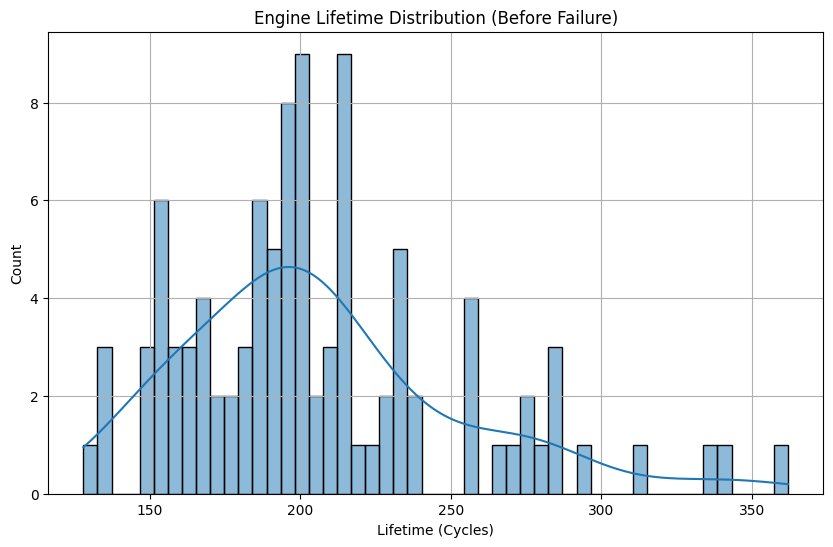

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

engine_lifetimes = train_df.groupby('unit_number')['time_in_cycles'].max()

plt.figure(figsize=(10,6))
sns.histplot(engine_lifetimes, bins=50, kde=True)
plt.title('Engine Lifetime Distribution (Before Failure)')
plt.xlabel('Lifetime (Cycles)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


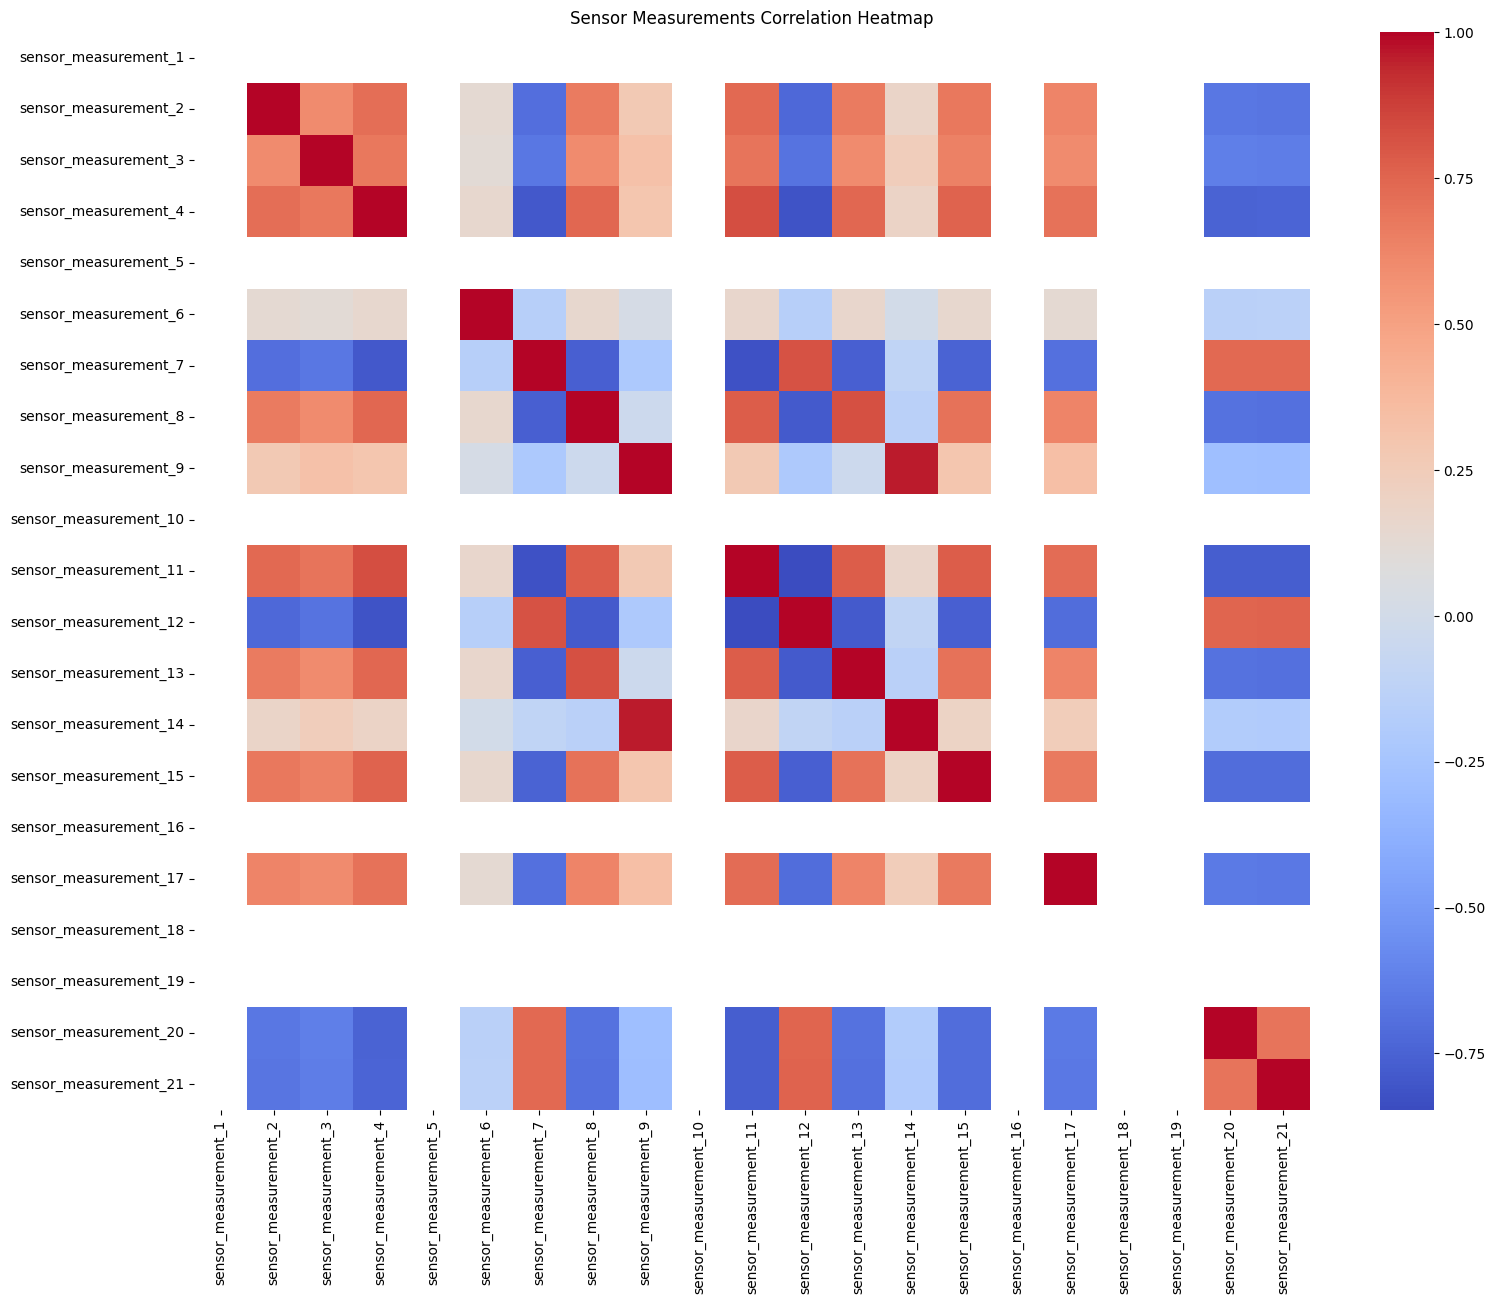

In [10]:
sensor_cols = [col for col in train_df.columns if 'sensor' in col]

plt.figure(figsize=(18,14))
sns.heatmap(train_df[sensor_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Sensor Measurements Correlation Heatmap')
plt.show()

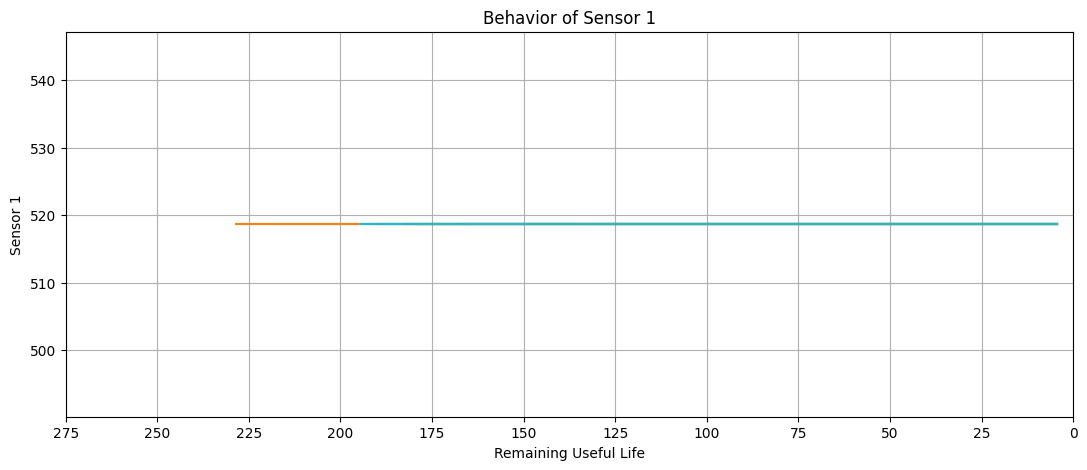

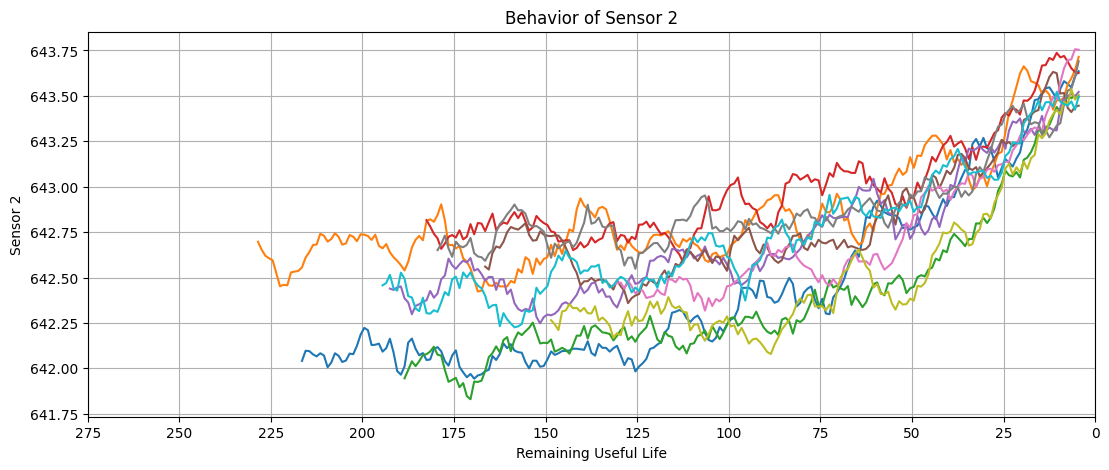

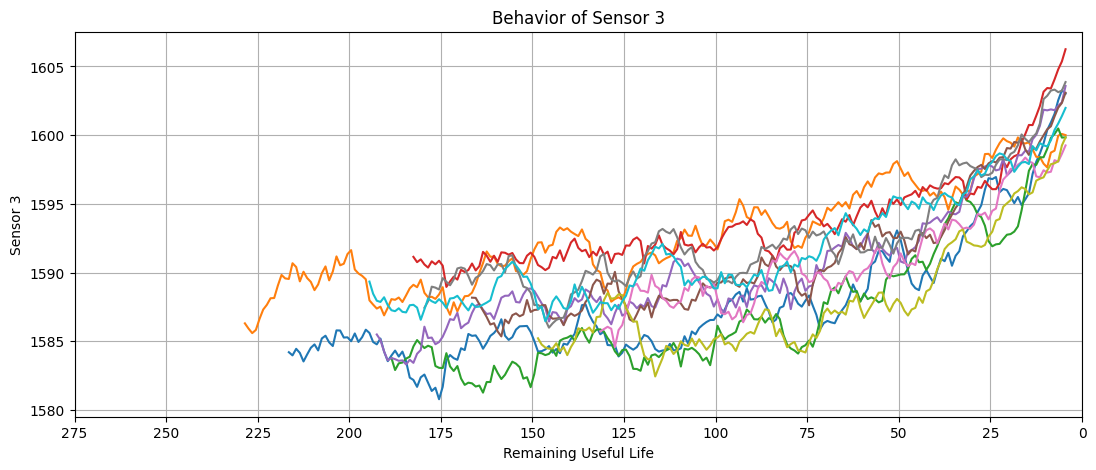

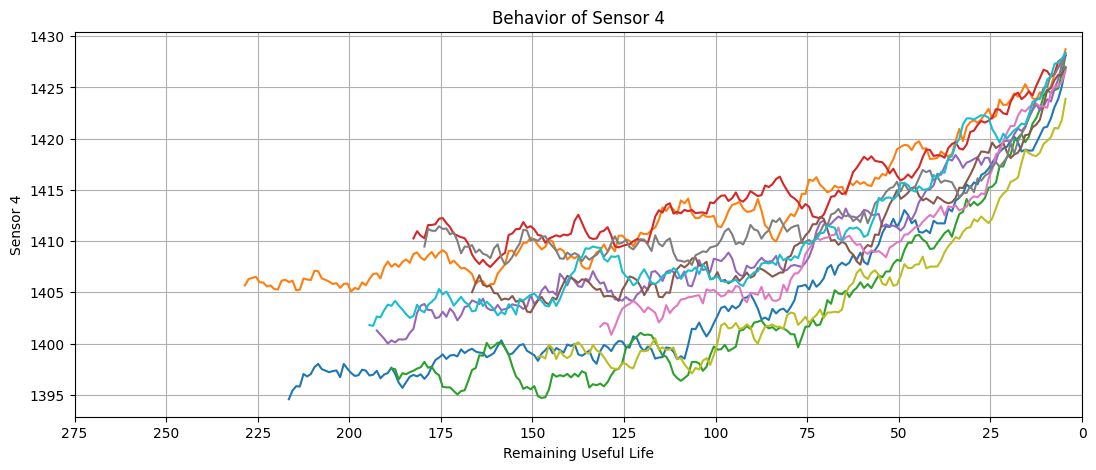

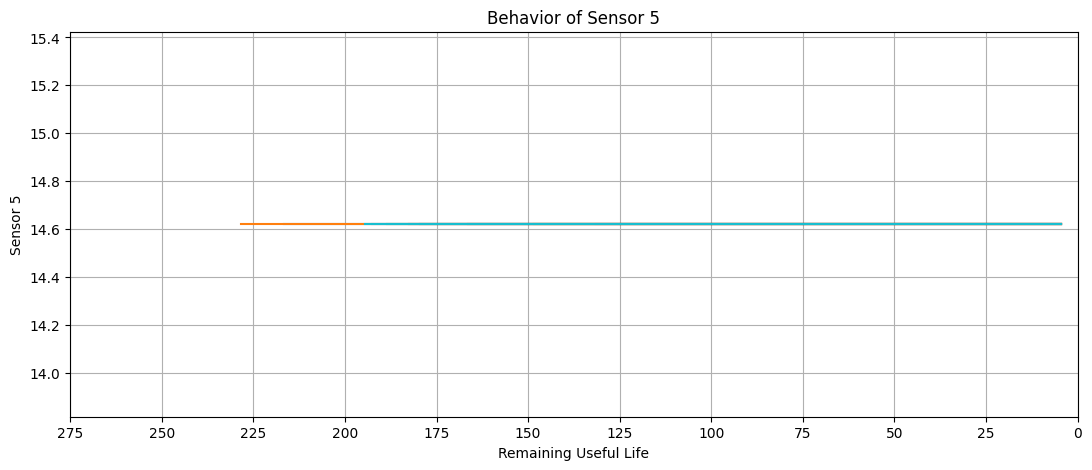

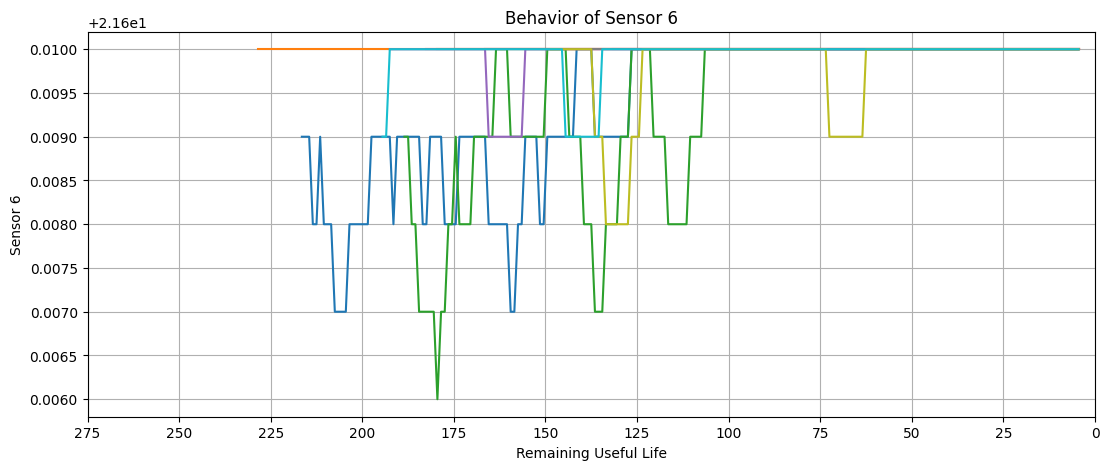

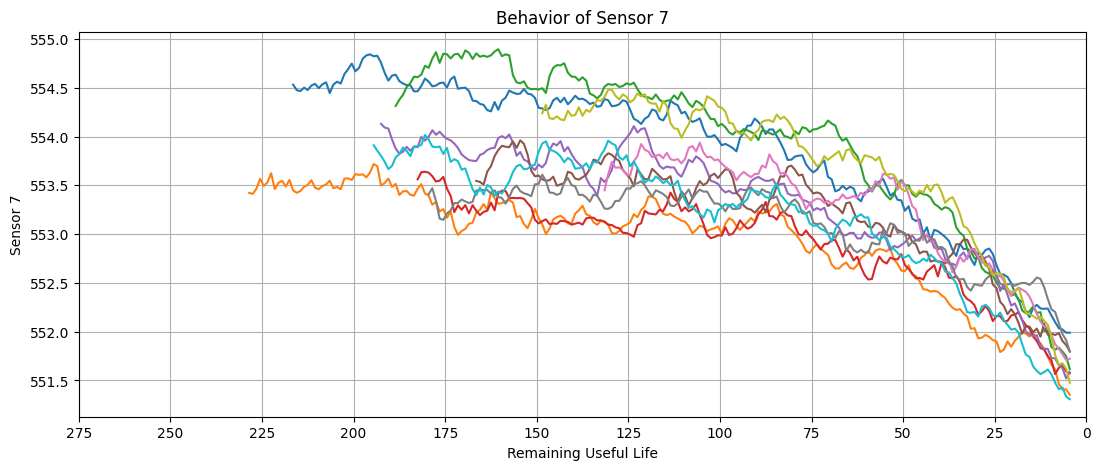

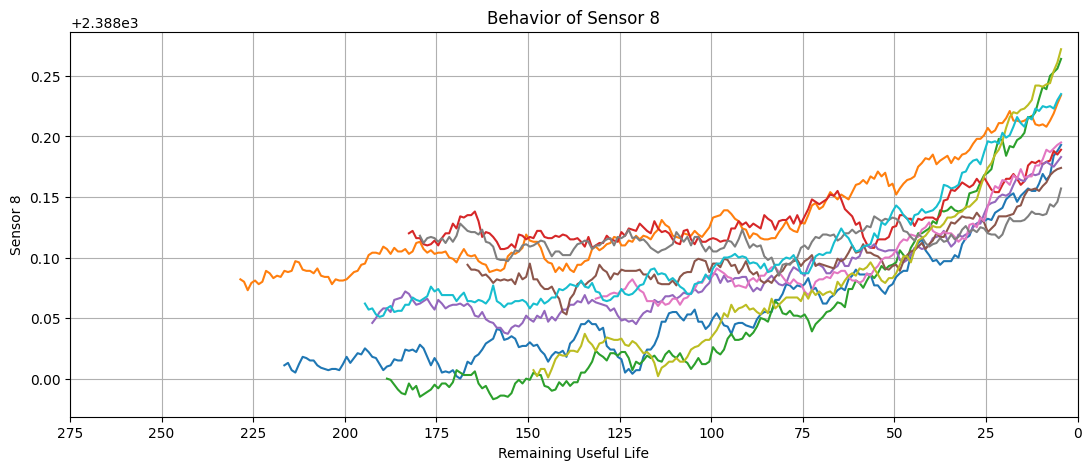

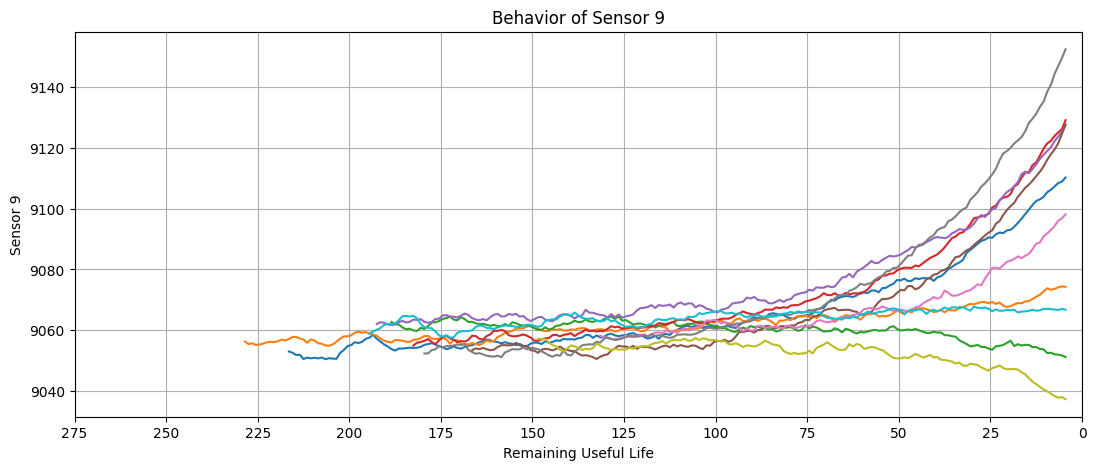

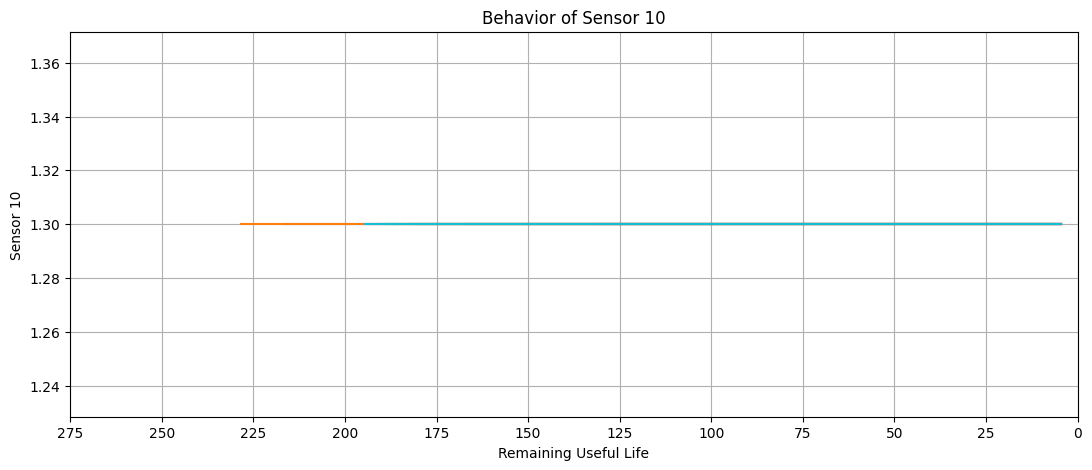

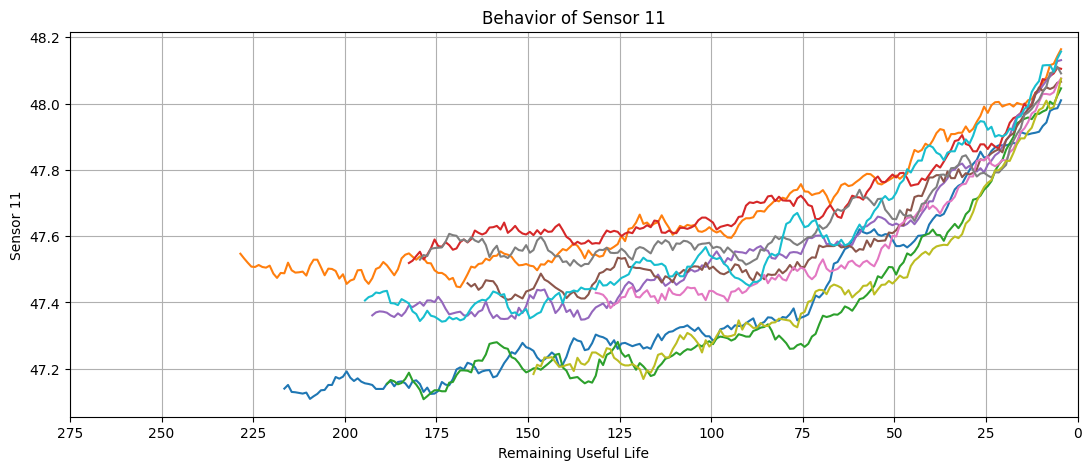

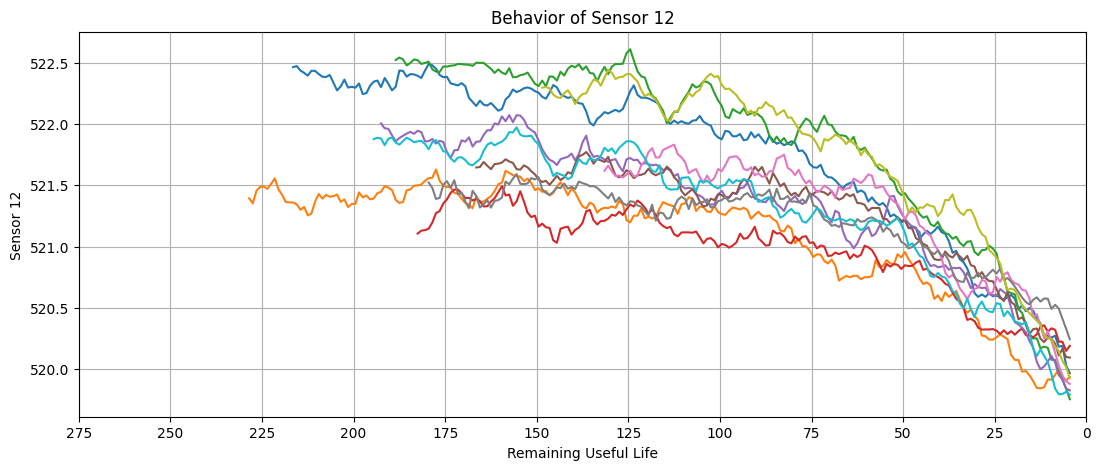

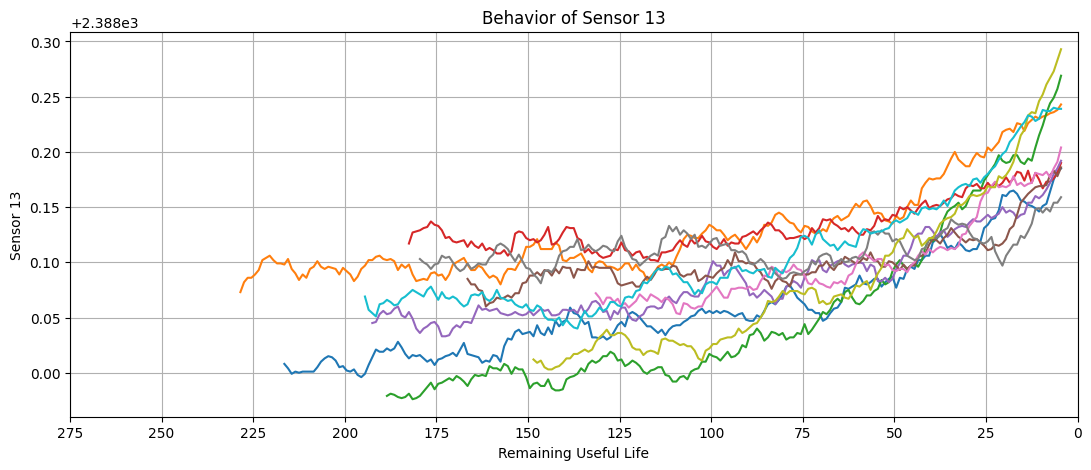

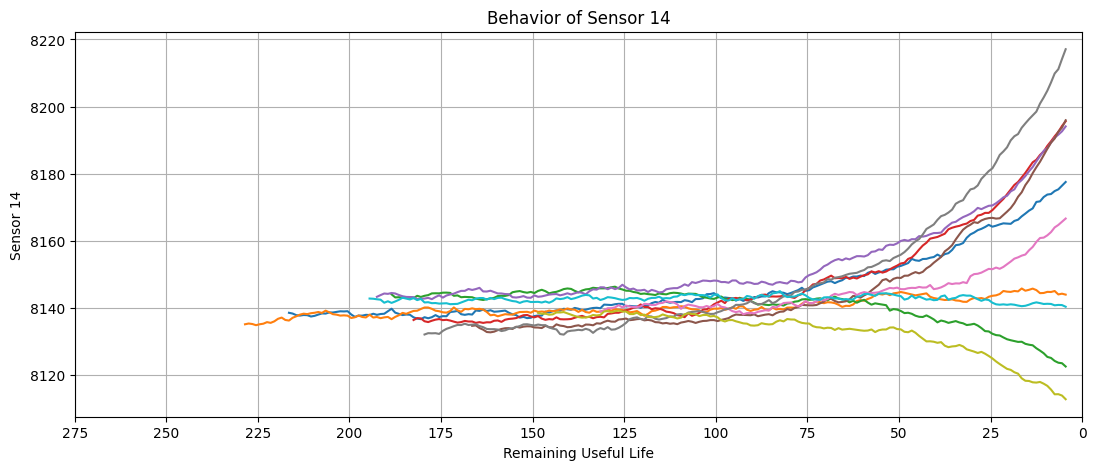

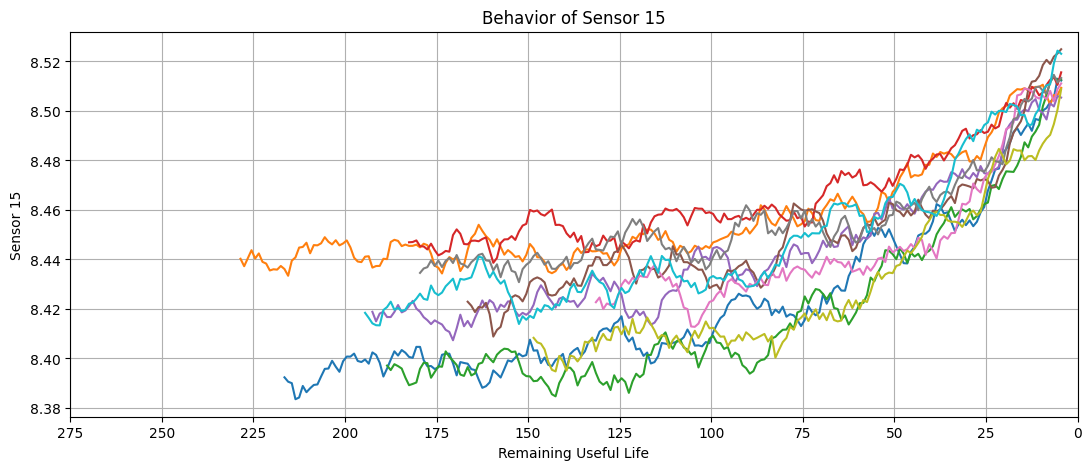

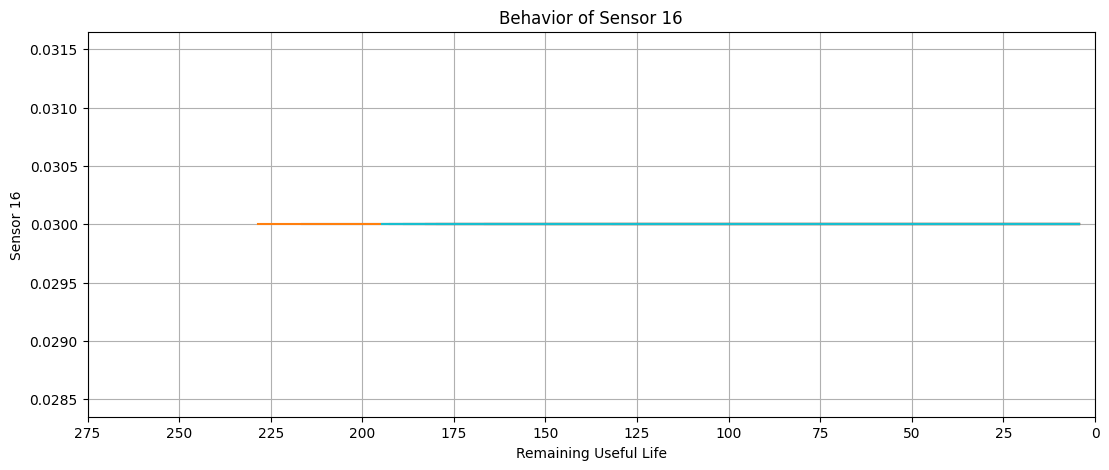

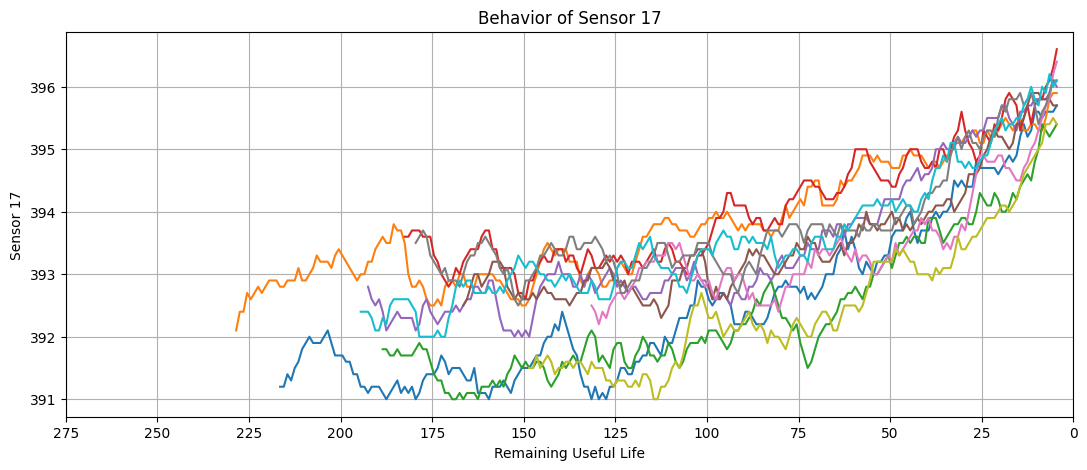

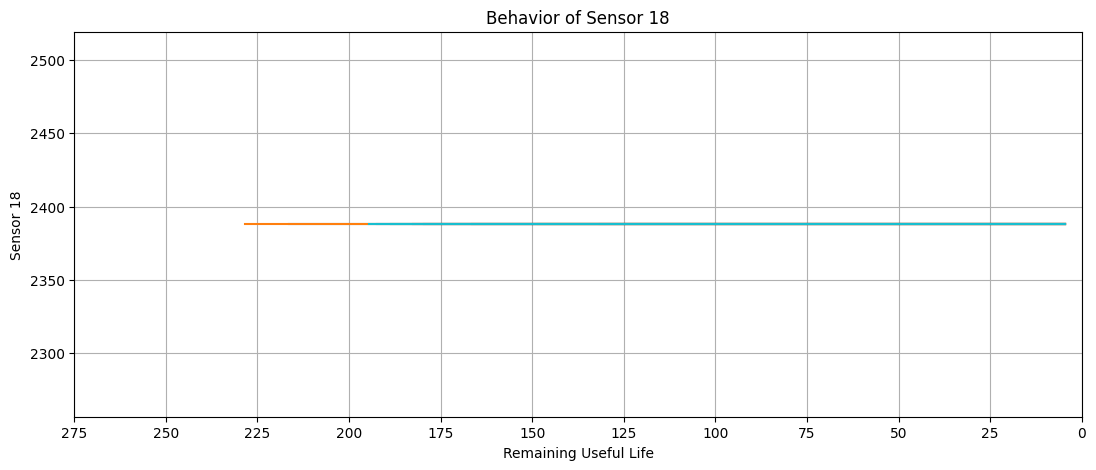

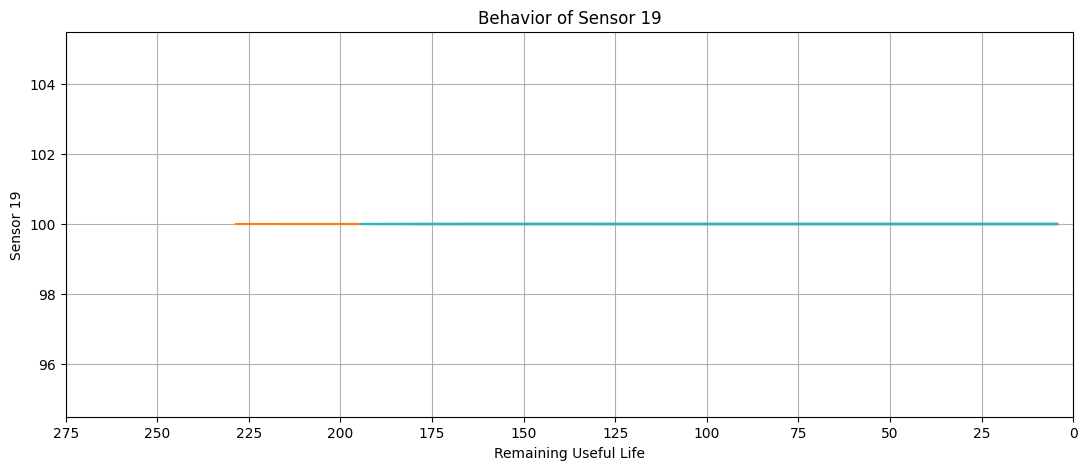

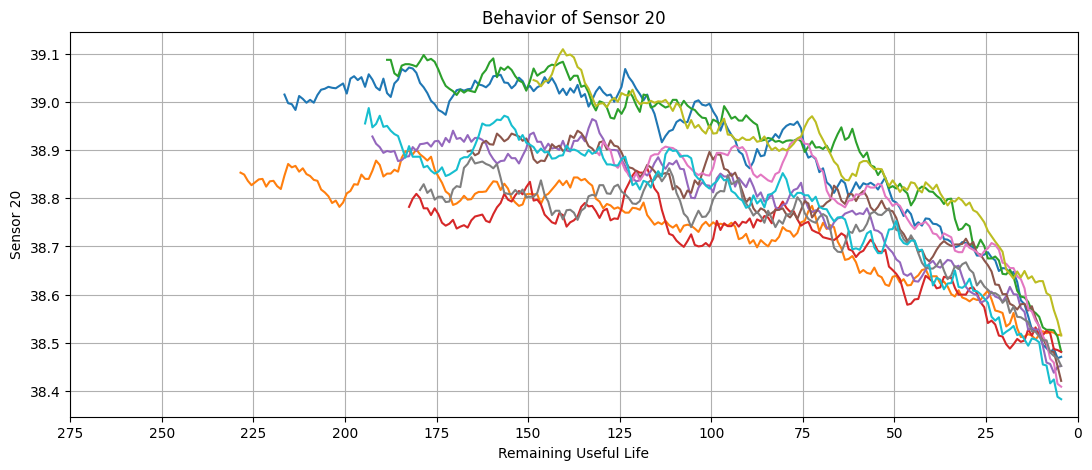

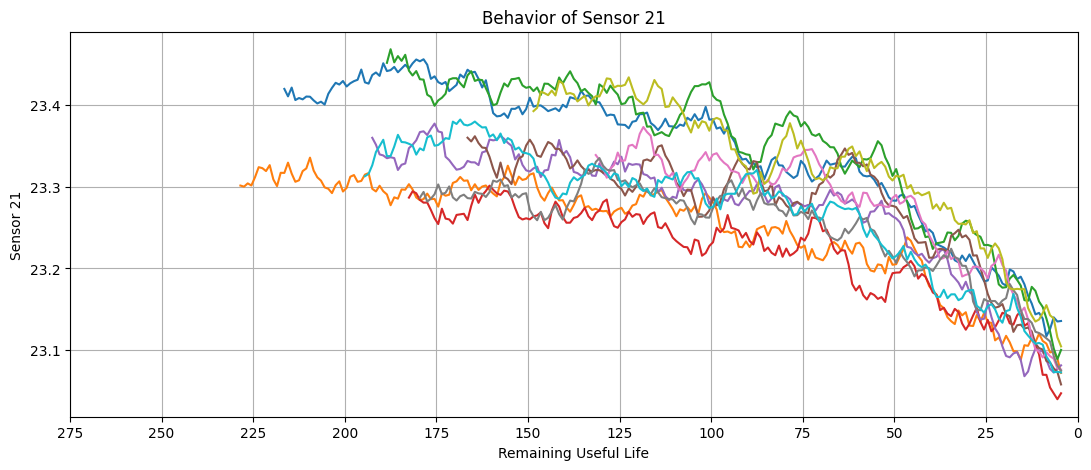

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# If needed, create RUL first
rul_per_engine = train_df.groupby('unit_number')['time_in_cycles'].max()
train_df['RUL'] = train_df.apply(lambda row: rul_per_engine[row['unit_number']] - row['time_in_cycles'], axis=1)

# Suppose you have a sensor name mapping dictionary
Sensor_dic = {f'sensor_measurement_{i}': f'Sensor {i}' for i in range(1, 22)}  # you can adjust this

# Function to plot one sensor
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   # Plot only units multiple of 10
            subset = df[df['unit_number'] == i]
            rolling_subset = subset.rolling(10).mean()
            plt.plot(rolling_subset['RUL'], rolling_subset[signal_name])

    plt.xlim(250, 0)  # Reverse X-axis (RUL decreasing)
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic.get(signal_name, signal_name))
    plt.xlabel('Remaining Useful Life')
    plt.title(f'Behavior of {Sensor_dic.get(signal_name, signal_name)}')
    plt.grid(True)
    plt.show()

# Plot each sensor one by one
for sensor in [col for col in train_df.columns if 'sensor_measurement' in col]:
    plot_signal(train_df, Sensor_dic, sensor)


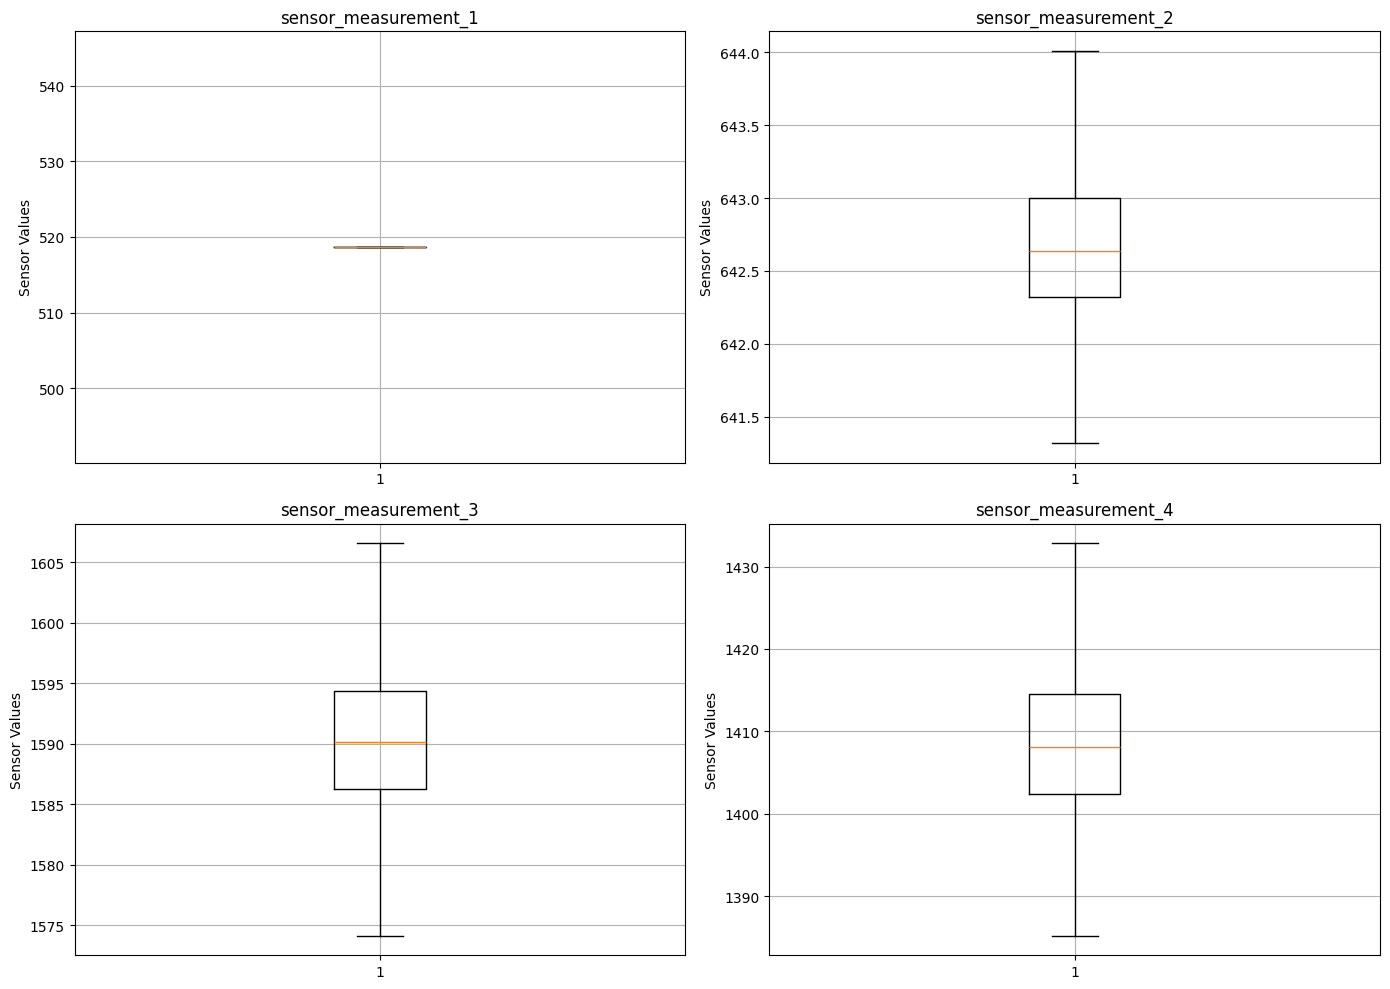

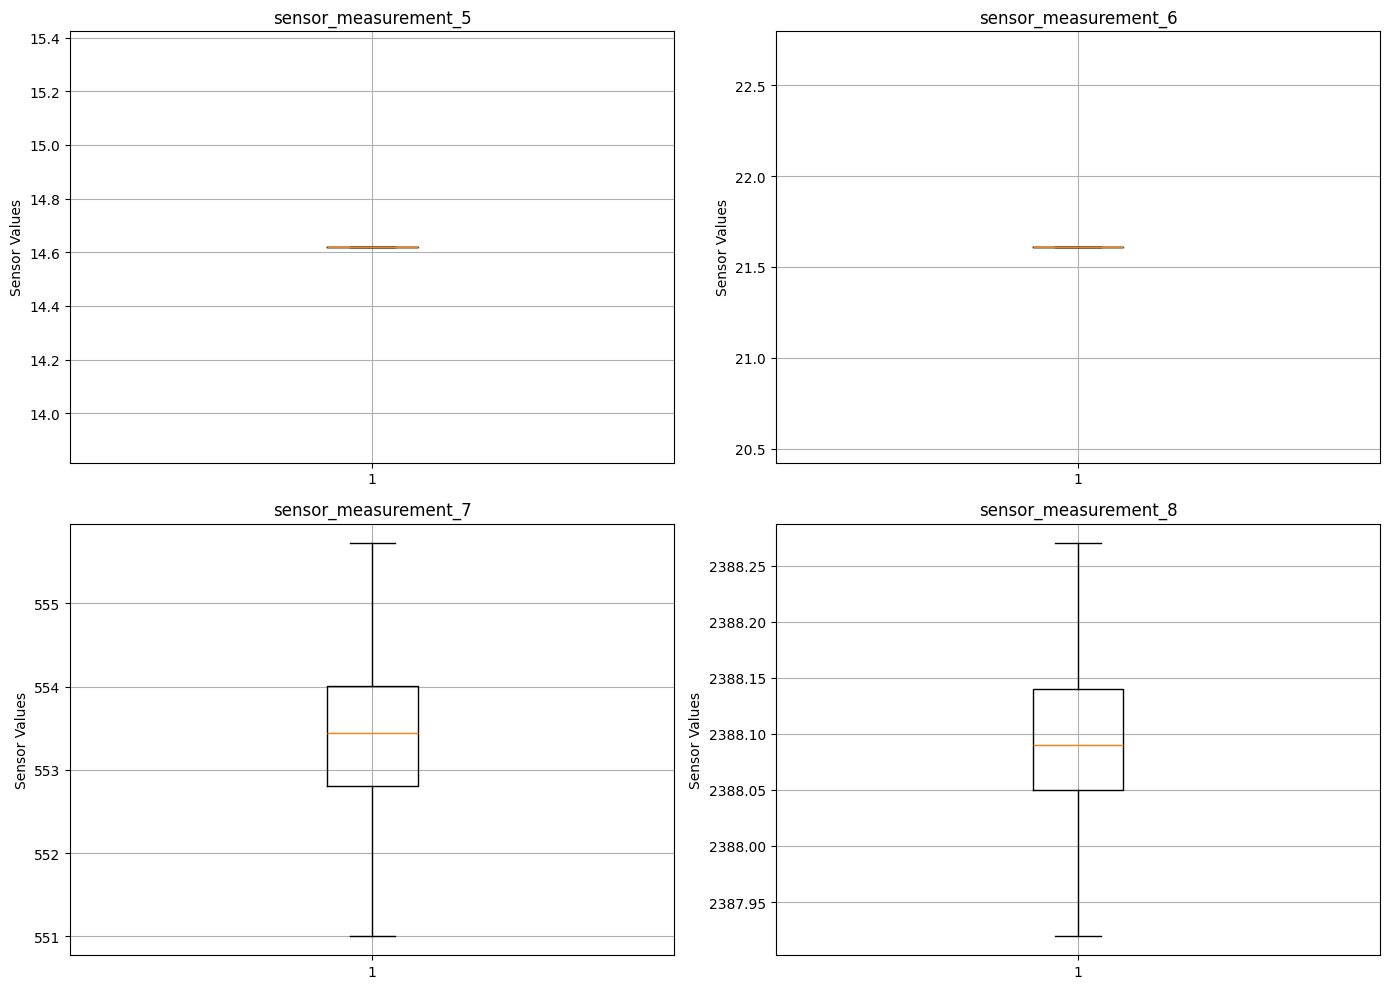

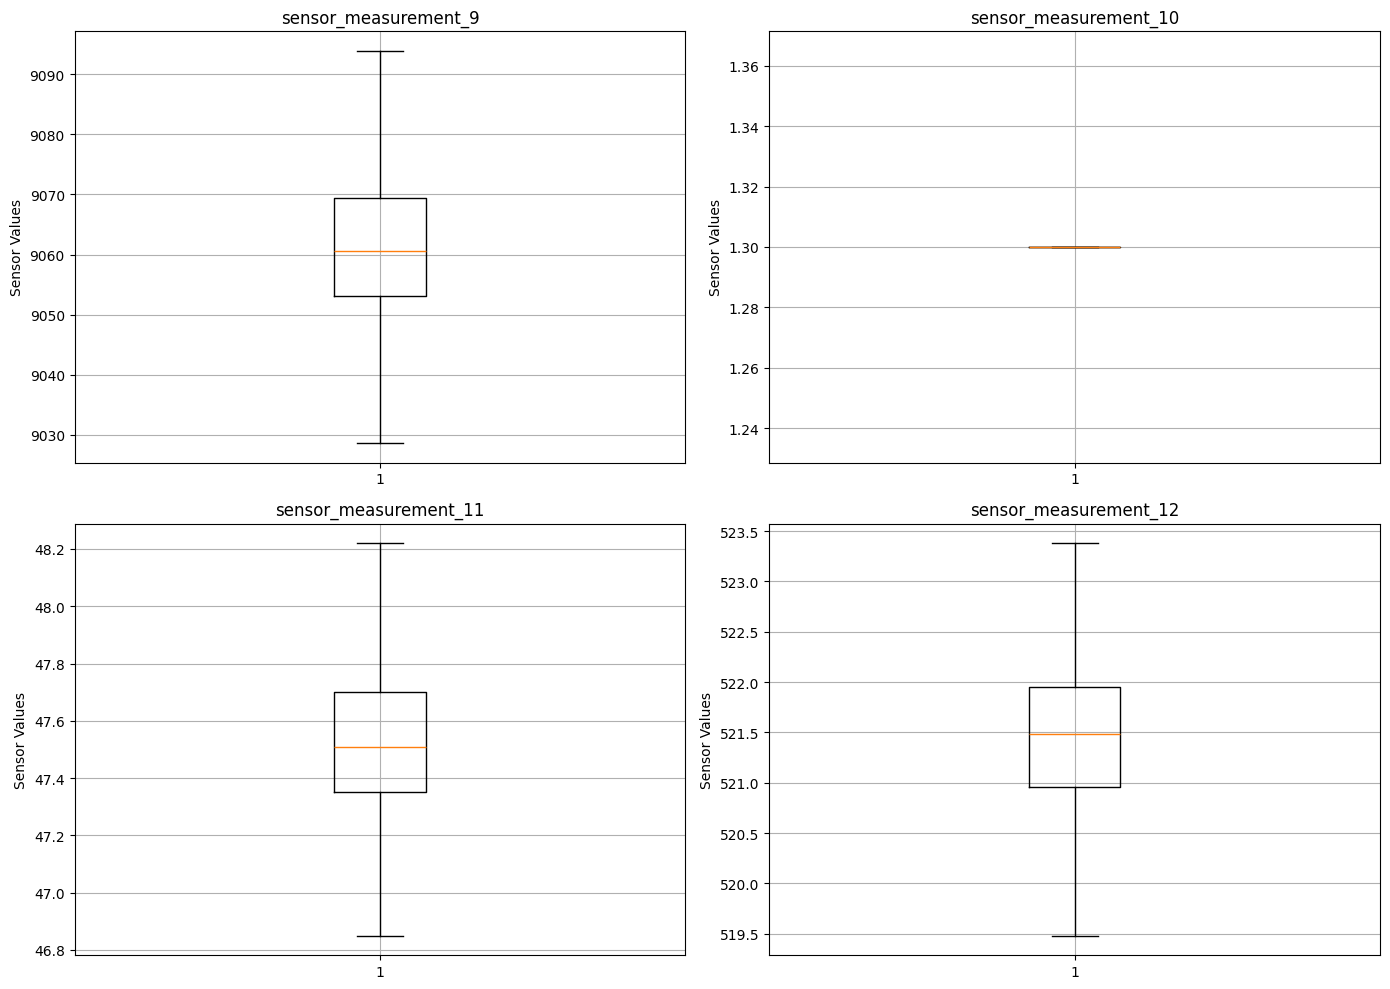

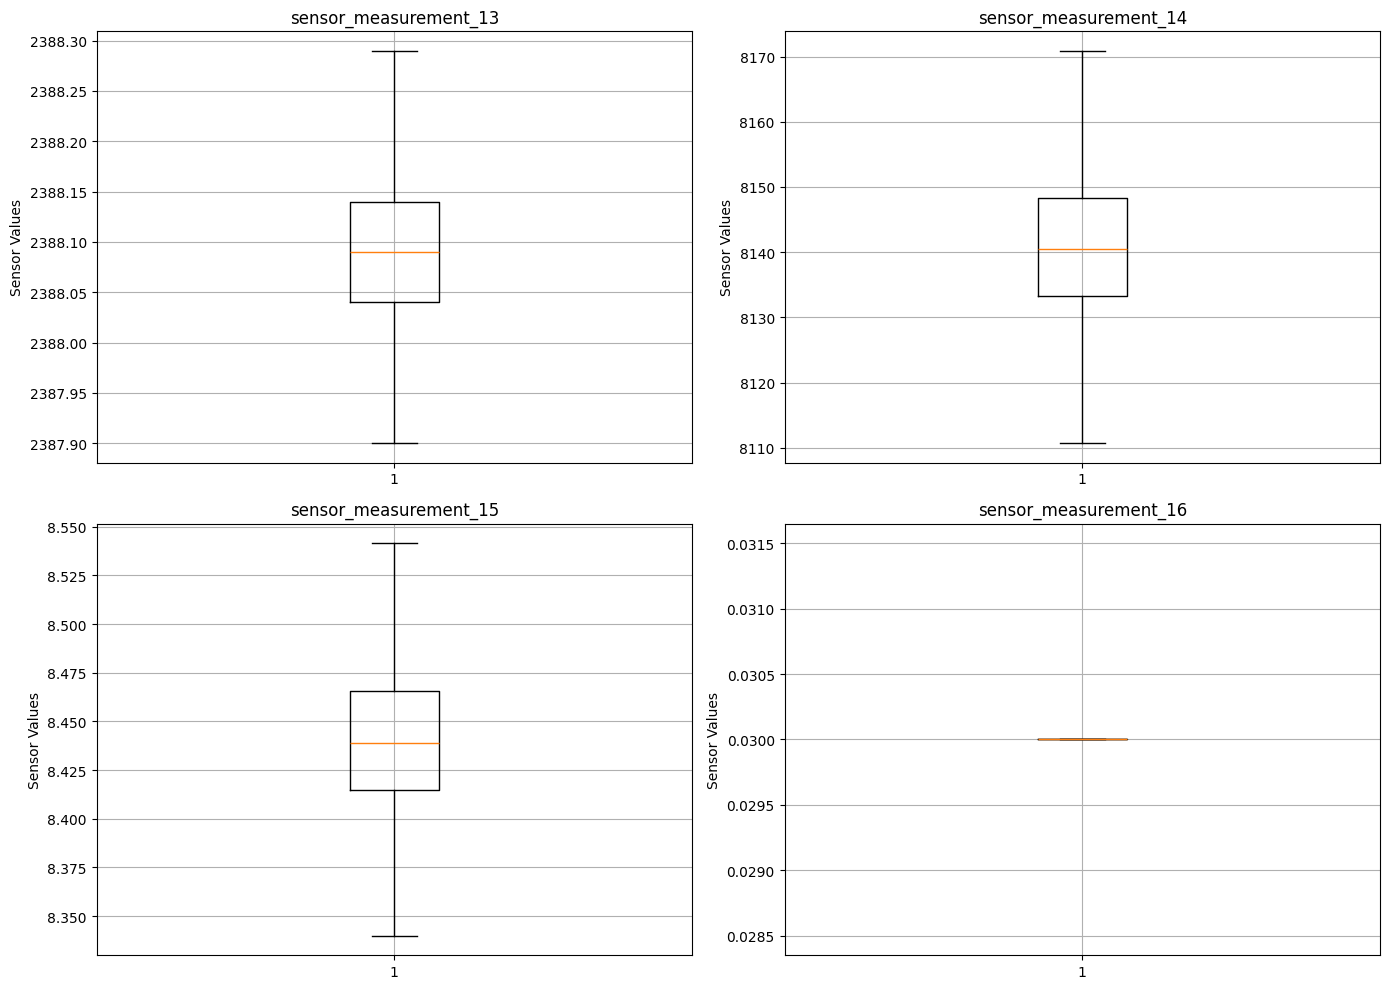

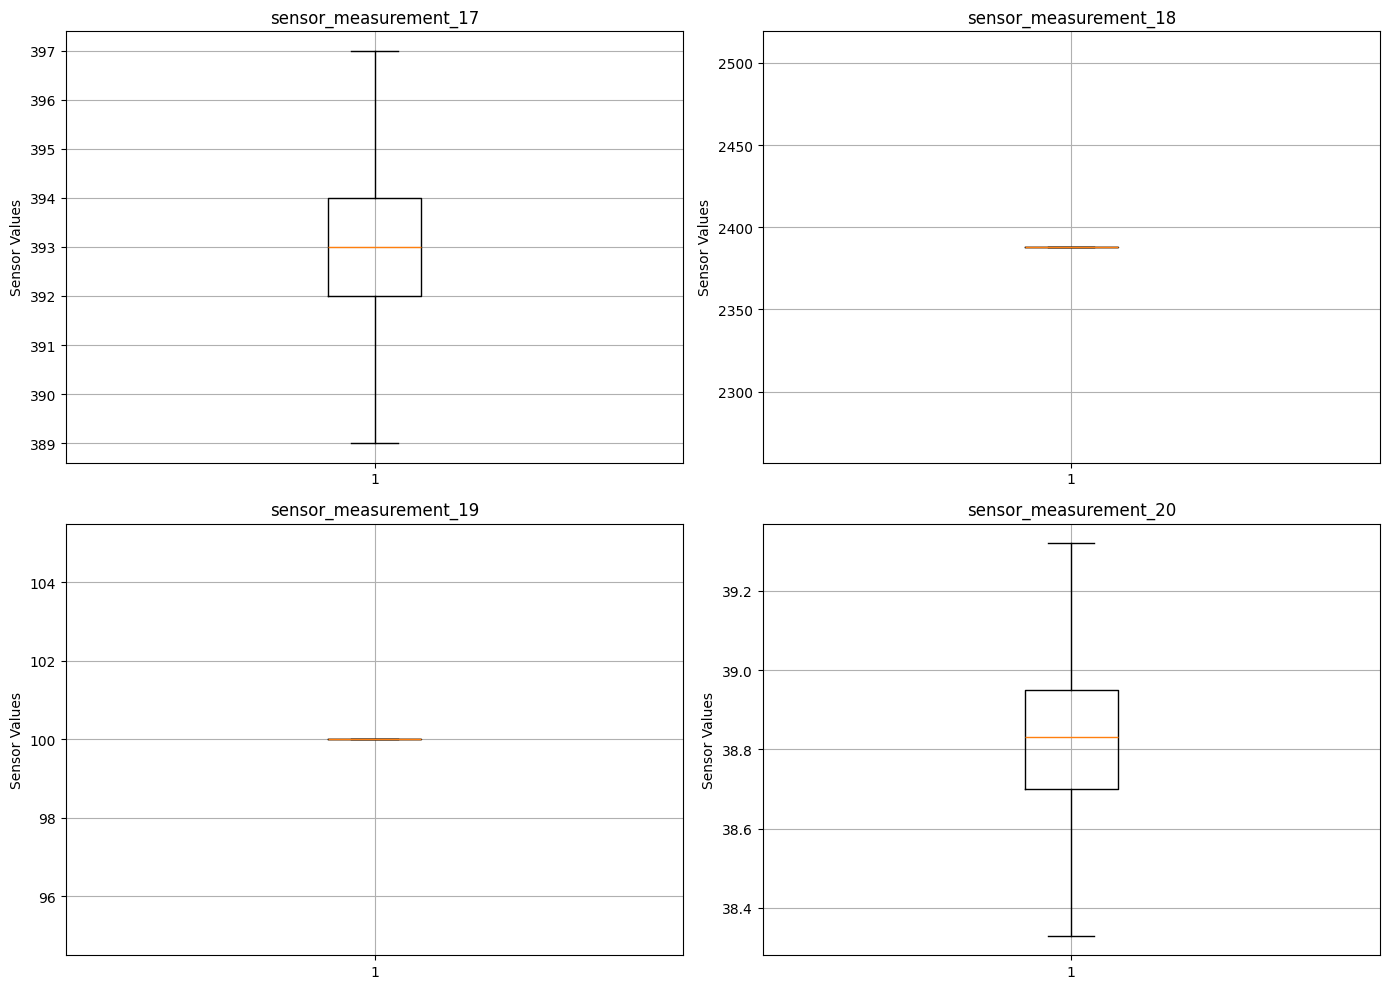

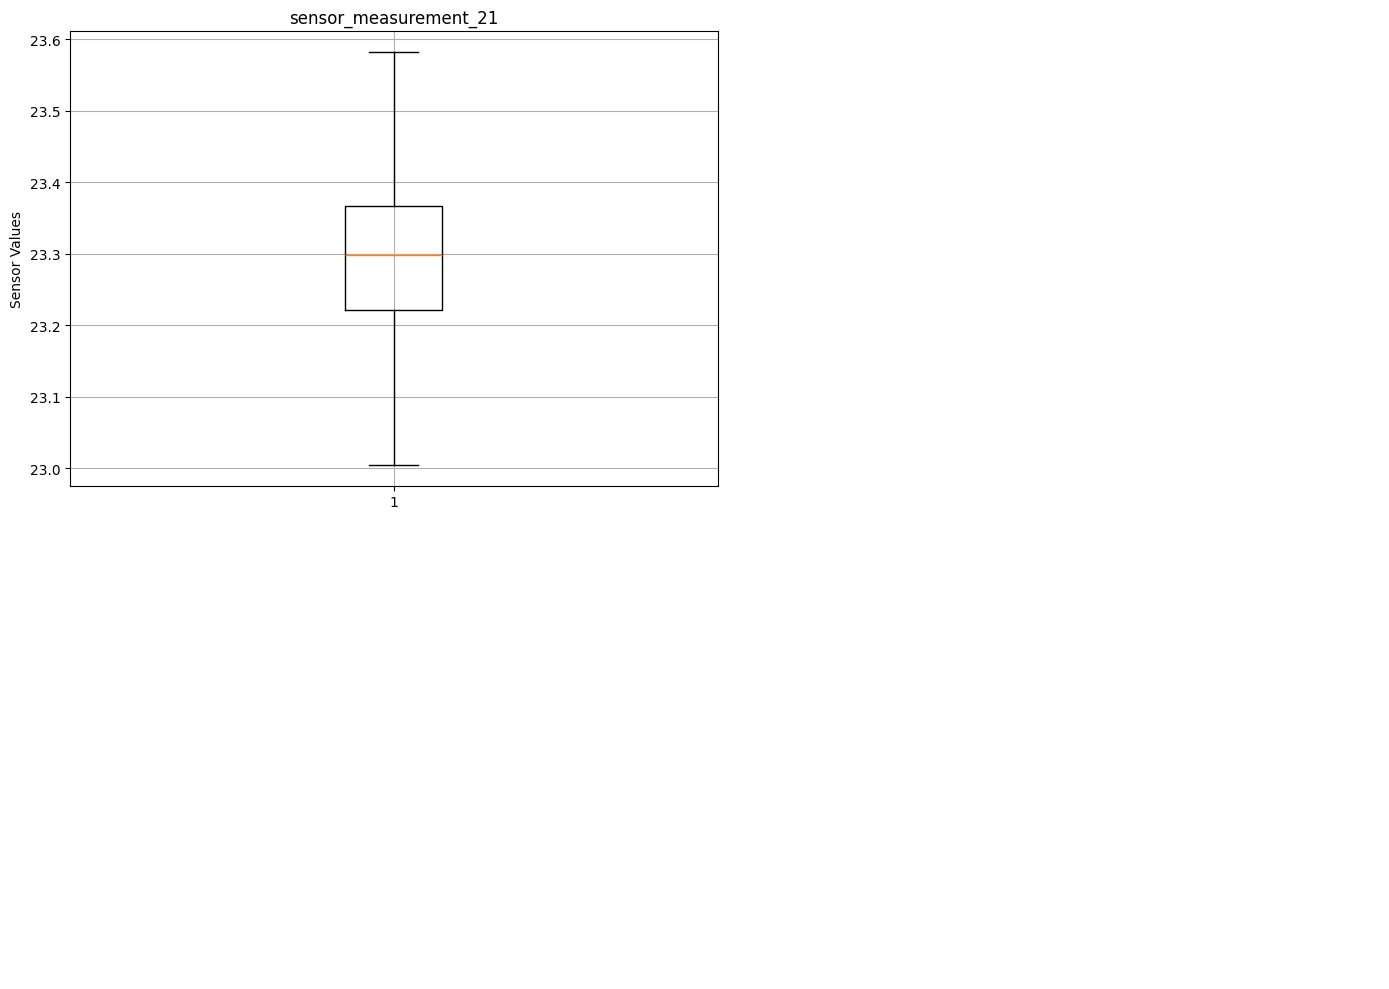

In [15]:
import matplotlib.pyplot as plt
import numpy as np

sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]

# Show 4 sensors per figure
sensors_per_fig = 4

for i in range(0, len(sensor_cols), sensors_per_fig):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for j in range(sensors_per_fig):
        if i + j < len(sensor_cols):
            sensor = sensor_cols[i + j]
            axes[j].boxplot(train_df[sensor], showfliers=False)
            axes[j].set_title(sensor)
            axes[j].set_ylabel('Sensor Values')
            axes[j].grid(True)
        else:
            axes[j].axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.show()
